The sole purpose of this file is to convert the CombinedCSI.mat file from the pipeline to a separate data.npy and mask.npy files for easier usage. You only have to insert the correct data folder name below and run the notebook. A CombinedCSI.mat file in that folder is required

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


def hamming_filter(arr, apply_dims, filter_width=100):
    """
    Apply an N‑D outer‑product Hamming filter along the specified axes.

    Parameters
    ----------
    arr : np.ndarray
        Input k‑space array. Wird hier direkt im k‑space gefiltert!
    apply_dims : sequence of int
        Achsen, entlang derer der Filter angewendet wird.
    filter_width : float, optional
        Prozentualer Anteil des Filters (100 = voller Hamming‑Window,
        50 = nur auf die äußeren 50 % angewendet).

    Returns
    -------
    out : np.ndarray
        Gefiltertes Array, gleiche Form wie `arr`.
    """
    out = arr.copy()
    for dim in apply_dims:
        n = arr.shape[dim]
        # Länge des 1D‑Hamming‑Fensters
        fw = int(np.ceil(filter_width/100 * n))
        # Erzeuge das 1D‑Fenster
        win = np.hamming(fw)
        # Links/rechts mit Einsen auffüllen, damit die Mitte unberührt bleibt
        pad_total = n - fw
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        full = np.concatenate([
            np.ones(pad_left, dtype=win.dtype),
            win,
            np.ones(pad_right, dtype=win.dtype)
        ])
        # Für Broadcast auf die korrekte Dimension bringen
        shape = [1] * arr.ndim
        shape[dim] = n
        full = full.reshape(shape)
        # multiplikative Kombination (OuterProduct über alle dims)
        out = out * full
    return out

# Beispielnutzung:
# kspace: dein komplexes k‑space-Array (z.B. nach ifftshift/ifft)
# dims = [0,1,2]  # Hamming auf x,y,z
# kspace_filtered = hamming_filter(kspace, dims, filter_width=100)


In [2]:
data_folder_name = "Simulated_Lesion_GT"

data = loadmat(f'{data_folder_name}/Lesion_120pts.mat')
Daten = data['csi_data_lr']['Data'][0,0]

Daten_fft = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(Daten, axes=-2), axis=-2), axes=-2)

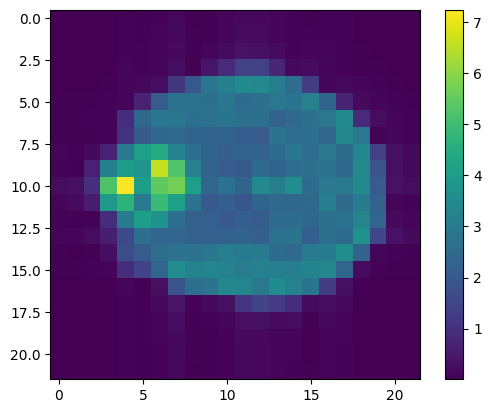

In [3]:
z, t, T = 10, 78, 5
Slice = np.abs(Daten_fft)[:, :, z, t, T]

plt.imshow(Slice)
plt.colorbar()
plt.show()

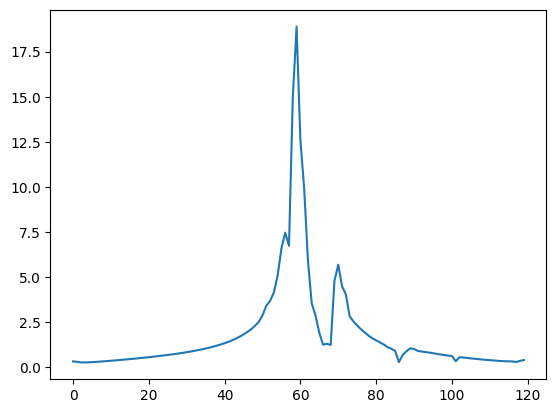

In [4]:
x,y,z,T = 8,10,10,2

Line = np.abs(Daten_fft)[x,y,z,:,T]

plt.plot(Line)

# Simulate noise

In [5]:
import numpy as np
from pathlib import Path

# Parameter
Noisesigma = 97.66666666
filter_width = 100

# 4 verschiedene Instanzen erzeugen und speichern
for i in range(1, 5):
    out_dir = Path(f"Simulated_Lesion_{i}")
    out_dir.mkdir(parents=True, exist_ok=True)

    # eigener RNG pro Instanz (reproduzierbar via Seed)
    rng = np.random.default_rng(seed=10_000 + i)

    # --- Go to k-space ---
    k_space = np.fft.fftshift(
        np.fft.fftn(Daten, axes=(0, 1, 2)),
        axes=(0, 1, 2)
    )

    # --- generate noise (komplexes Gauß-Rauschen) ---
    noise = (rng.standard_normal(k_space.shape) + 1j * rng.standard_normal(k_space.shape)) * Noisesigma
    k_space_noisy = k_space + noise

    # --- define hamming filter ---
    kspace_filtered = hamming_filter(k_space_noisy, apply_dims=[0, 1, 2], filter_width=filter_width)

    # --- back to image space ---
    noise_data = np.fft.ifftn(np.fft.ifftshift(kspace_filtered, axes=(0, 1, 2)), axes=(0, 1, 2))

    # Optional: FID-Fourier entlang der -2 Achse (wie in deinem Beispiel)
    noise_data_fft = np.fft.ifftshift(
        np.fft.fft(np.fft.fftshift(noise_data, axes=-2), axis=-2),
        axes=-2
    )

    # Speichern – gewünscht ist noise_data als data.npy
    np.save(out_dir / "data.npy", noise_data)
    # Optional zusätzlich:
    # np.save(out_dir / "data_fft.npy", noise_data_fft)

print("Fertig: Simulated_Lesion_double_1..4 mit jeweils data.npy erstellt.")


Fertig: Simulated_Lesion_double_1..4 mit jeweils data.npy erstellt.


# Save data

In [6]:
#np.save(f'{data_folder_name}/data.npy', noise_data)

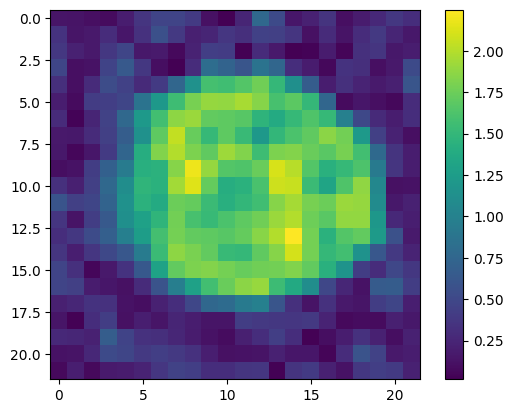

In [7]:
z, t, T = 10, 1, 5
Slice = np.abs(noise_data)[:, :, z, t, T]

plt.imshow(Slice)
plt.colorbar()
plt.show()

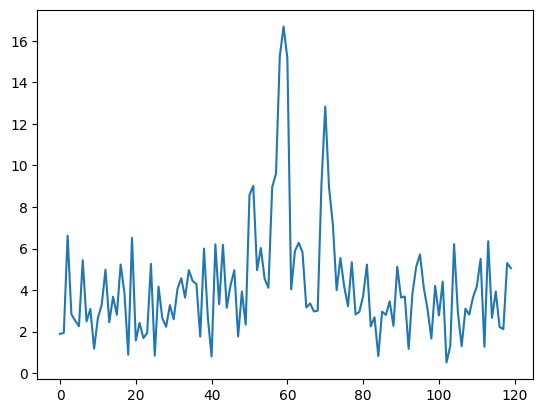

In [8]:
x,y,z,T = 8,10,10,5

Line = np.abs(noise_data_fft)[x,y,z,:,T]

plt.plot(Line)

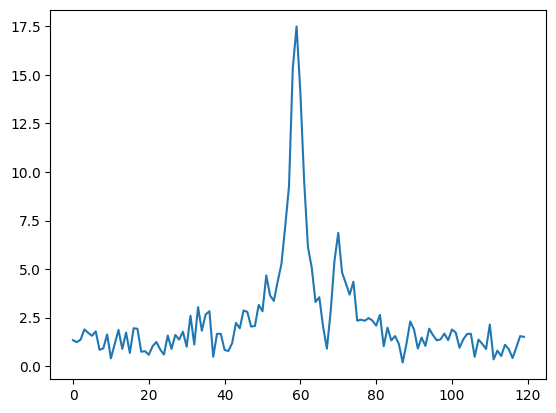

In [9]:
x,y,z,T = 8,10,10,5

Line = np.abs(np.mean(noise_data_fft[x, y, z, :, :], axis=-1))


plt.plot(Line)